<a href="https://colab.research.google.com/github/evidal1990/data_science/blob/main/data_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalando sklearn

In [ ]:
%pip install scikit-learn
%pip install category_encoders
%pip install imbalanced-learn
%pip install catboost


#### Importando as bibliotecas necessárias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

#### Lendo dados da base após análise

In [ ]:
df_accidents = pd.read_csv(
    "/content/datatran2018_2024_v3.csv",
    parse_dates=["mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421506 entries, 0 to 421505
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   id                        421506 non-null  float64       
 1   tipo_data                 421506 non-null  object        
 2   mes_ano                   421506 non-null  datetime64[ns]
 3   dia_semana                421506 non-null  object        
 4   horario                   421506 non-null  object        
 5   fase_dia                  421506 non-null  object        
 6   condicao_metereologica    421506 non-null  object        
 7   uf                        421506 non-null  object        
 8   br                        421506 non-null  float64       
 9   br_tipo                   421506 non-null  object        
 10  km                        421506 non-null  object        
 11  uso_solo                  421506 non-null  object        
 12  ti

#### Removendo colunas que não serão utilizadas para a classificação

In [ ]:
df = df_accidents.copy()
df.drop(columns=[
    "horario",
    "km",
    "tipo_data",
    "causa_acidente_categoria",
    "mes_ano",
    "pessoas",
    "veiculos",
    "mortos",
    "ilesos",
    "feridos",
    "br_tipo"
], inplace=True)

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421506 entries, 0 to 421505
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      421506 non-null  float64
 1   dia_semana              421506 non-null  object 
 2   fase_dia                421506 non-null  object 
 3   condicao_metereologica  421506 non-null  object 
 4   uf                      421506 non-null  object 
 5   br                      421506 non-null  float64
 6   uso_solo                421506 non-null  object 
 7   tipo_pista              421506 non-null  object 
 8   sentido_via             421506 non-null  object 
 9   tipo_acidente           421506 non-null  object 
 10  causa_acidente          421506 non-null  object 
 11  classificacao_acidente  421506 non-null  object 
dtypes: float64(2), object(10)
memory usage: 38.6+ MB


#### Agrupando tipos de acidente para facilitar a classificação

In [ ]:
df["tipo_acidente"].value_counts()

,count
tipo_acidente,
Colisão traseira,80367
Saída de leito carroçável,66441
Colisão transversal,53839
Colisão lateral,53646
Tombamento,35221
Colisão com objeto,31363
Colisão frontal,28304
Atropelamento de pedestre,19665
Queda de ocupante de veículo,19033


In [ ]:
accidents = {
    "Colisão traseira": "Colisão",
    "Colisão transversal": "Colisão",
    "Colisão frontal": "Colisão",
    "Colisão lateral": "Colisão",
    "Colisão com objeto": "Colisão",
    "Atropelamento de animal": "Outros",
    "Atropelamento de pedestre": "Outros",
    "Capotamento": "Perda de controle",
    "Tombamento": "Perda de controle",
    "Saída de leito carroçável": "Perda de controle",
    "Engavetamento": "Outros",
    "Queda de ocupante de veículo": "Outros",
    "Incêndio": "Outros"
}

df["tipo_acidente"] = df["tipo_acidente"].map(accidents)
df["tipo_acidente"].value_counts()

,count
tipo_acidente,
Colisão,247519
Perda de controle,113623
Outros,60364


#### Definir target

In [ ]:
target_col = 'tipo_acidente'

#### Definir variáveis

In [ ]:
# 1. Definir variáveis
categorical_features = [
    'dia_semana',
    'fase_dia',
    'condicao_metereologica',
    'uso_solo',
    'tipo_pista',
    'sentido_via',
    'causa_acidente',
    'br'
]

#### Separar dados

In [ ]:
X = df[categorical_features]
y = df[target_col]

#### OneHotEncoder + RandomForestClassifier

Gera variáveis binárias, o que mantém a informação completa das categorias. Funciona bem com RandomForest, que lida naturalmente com dados esparsos. Porém, com alta cardinalidade, a explosão de colunas aumenta muito o consumo de memória e processamento, impactando escalabilidade.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ))
])

# 3. Hiperparâmetros
param_distributions = {
    'classifier__n_estimators': randint(50, 100),
    'classifier__max_depth': randint(5, 10),
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__bootstrap': [True, False]
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# 5. Treinar o modelo
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'classifier__bootstrap': True, 'classifier__max_depth': 9, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 9, 'classifier__n_estimators': 93}
Melhor score (balanced_accuracy): 0.6342059448379258
                   precision    recall  f1-score   support

          Colisão       0.79      0.64      0.71     74256
           Outros       0.70      0.47      0.56     18109
Perda de controle       0.45      0.72      0.55     34087

         accuracy                           0.64    126452
        macro avg       0.65      0.61      0.61    126452
     weighted avg       0.69      0.64      0.65    126452



#### Matriz de confusão

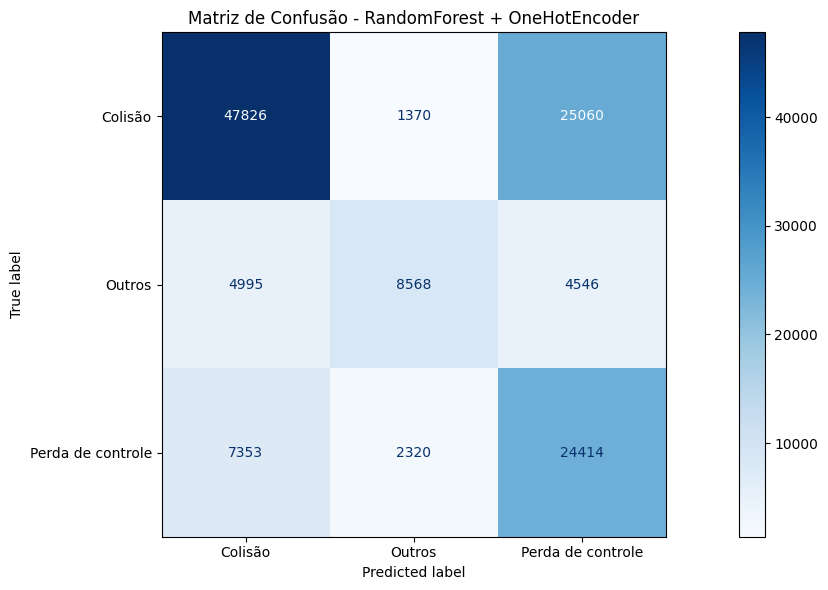

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=random_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.best_estimator_.classes_)

fig, ax = plt.subplots(figsize=(15, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão - RandomForest + OneHotEncoder')
# plt.xticks(ha="right")
plt.tight_layout()
plt.show()

#### TargetEncoder + RandomForestClassifier

Codifica categorias pela média do target, reduzindo dimensionalidade. RandomForest lida bem com essa codificação, aproveitando as informações numéricas sem o custo da explosão de features, mantendo boa performance e escalabilidade mesmo com dados grandes e muitas categorias.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 3. Hiperparâmetros
param_distributions = {
    'clf__n_estimators': randint(50, 100),          # de 50 até 149
    'clf__max_depth': randint(5, 10),               # de 5 até 19
    'clf__min_samples_split': randint(2, 11),       # de 2 até 10
    'clf__min_samples_leaf': randint(1, 5),         # de 1 até 4
    'clf__max_features': ['sqrt', 'log2']
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=2,
    random_state=42,
    verbose=1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__max_depth': 8, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 3, 'clf__n_estimators': 70}
Melhor score (balanced_accuracy): 0.6341331884103548
                   precision    recall  f1-score   support

          Colisão       0.81      0.69      0.75     74256
           Outros       0.59      0.53      0.56     18109
Perda de controle       0.50      0.69      0.58     34087

         accuracy                           0.67    126452
        macro avg       0.63      0.64      0.63    126452
     weighted avg       0.70      0.67      0.67    126452



#### Matriz de confusão

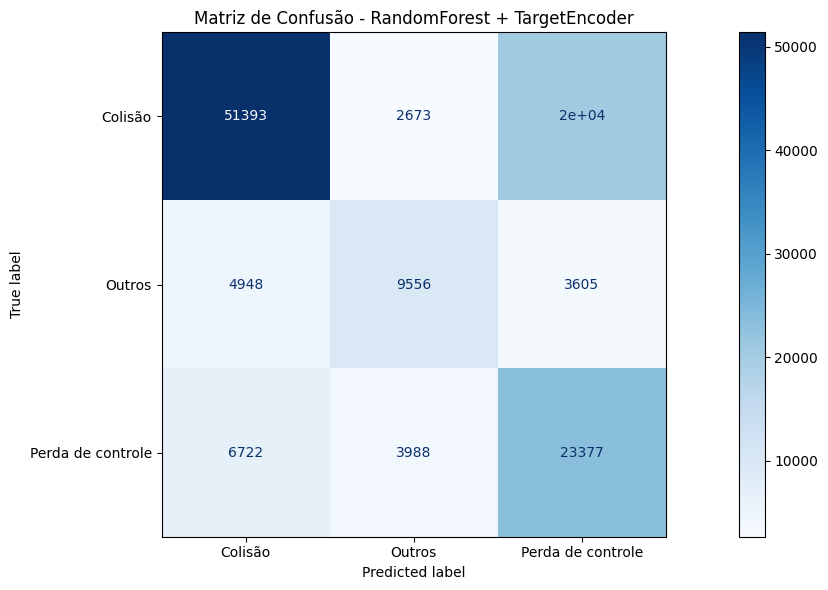

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(15, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão - RandomForest + TargetEncoder')
plt.tight_layout()
plt.show()


#### TargetEncoder + DecisionTreeClassifier

Simples e eficiente, reduz dimensionalidade e facilita a construção da árvore. Porém, DecisionTree é mais propenso a overfitting que RandomForest, pois não tem mecanismos internos de regularização tão eficazes, embora seja rápido e interpretável para dados menores ou mais simples.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# 3. Hiperparâmetros
param_distributions = {
    'clf__max_depth': randint(5, 10),               # de 5 até 19
    'clf__min_samples_split': randint(2, 11),       # de 2 até 10
    'clf__min_samples_leaf': randint(1, 5),         # de 1 até 4
    'clf__max_features': ['sqrt', 'log2']
}

# 4. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_log_loss',
    n_jobs=2,
    verbose=1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (balanced_accuracy):", random_search.best_score_)

# 7. Prever
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# 8. Avaliar
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__max_depth': 9, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 4}
Melhor score (balanced_accuracy): -0.8714687331667293
                   precision    recall  f1-score   support

          Colisão       0.81      0.67      0.73     74256
           Outros       0.47      0.52      0.50     18109
Perda de controle       0.50      0.66      0.57     34087

         accuracy                           0.65    126452
        macro avg       0.59      0.62      0.60    126452
     weighted avg       0.68      0.65      0.66    126452



#### Matriz de confusão

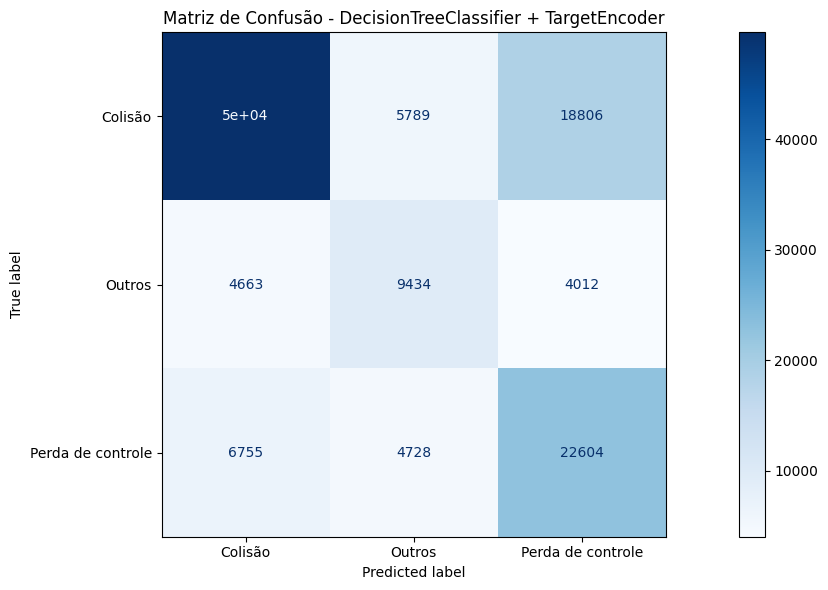

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

fig, ax = plt.subplots(figsize=(15, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Matriz de Confusão - DecisionTreeClassifier + TargetEncoder')
plt.tight_layout()
plt.show()


#### TargetEnconder + XGBoost

Combinação muito eficiente. TargetEncoder transforma categorias em valores numéricos densos, o que é ideal para XGBoost, que espera entradas numéricas. XGBoost lida muito bem com grandes volumes, possui regularização e técnicas internas que evitam overfitting e aumentam a precisão.

In [ ]:
# 1. Separar treino e teste
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# 2. Aplicar encoding nas features categóricas antes do SMOTE
encoder = TargetEncoder(cols=categorical_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# 3. Aplicar SMOTE apenas nos dados de treino codificados
smote = SMOTE(random_state=42)

# 4. Aplicar SMOTE para gerar novas amostras na base de treino codificada
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# 5. Pipeline
pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_features)),
    ('clf', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1
    ))
])

# 6. Hiperparâmetros
param_distributions = {
    'clf__n_estimators': randint(50, 150),
    'clf__max_depth': randint(3, 10),
    'clf__learning_rate': uniform(0.01, 0.3),
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__gamma': uniform(0, 5)
}

# 7. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,
    scoring='recall_macro',
    n_jobs=1,
    random_state=42,
    verbose=1,
    error_score='raise'
)

# 8. Busca
random_search.fit(X_train_resampled, y_train_resampled)

# 9. Melhores parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (recall_macro):", random_search.best_score_)

# 10. Prever
best_model = random_search.best_estimator_
# Lembre-se de prever no X_test_encoded, não no X_test original
y_pred = best_model.predict(X_test_encoded)

# 11. Avaliar
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
print(classification_report(y_test_labels, y_pred_labels))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Melhores parâmetros: {'clf__colsample_bytree': np.float64(0.749816047538945), 'clf__gamma': np.float64(4.75357153204958), 'clf__learning_rate': np.float64(0.22959818254342154), 'clf__max_depth': 7, 'clf__n_estimators': 70, 'clf__subsample': np.float64(0.6624074561769746)}
Melhor score (recall_macro): 0.6450454017233199
                   precision    recall  f1-score   support

          Colisão       0.76      0.81      0.79     74256
           Outros       0.72      0.47      0.57     18109
Perda de controle       0.56      0.58      0.57     34087

         accuracy                           0.70    126452
        macro avg       0.68      0.62      0.64    126452
     weighted avg       0.70      0.70      0.70    126452



#### Matriz de confusão

Text(0.5, 1.0, 'Matriz de Confusão')

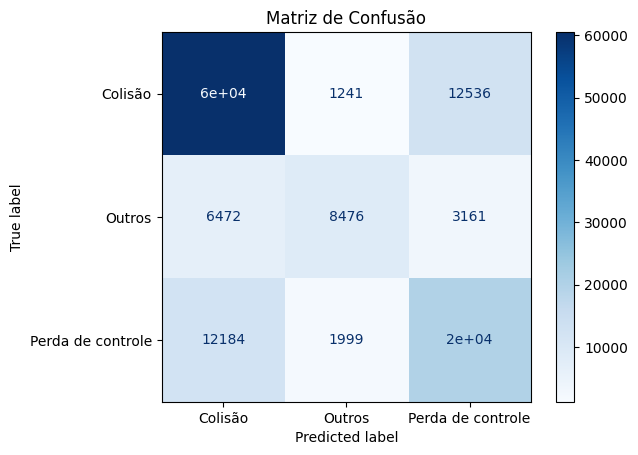

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_pred_labels,
    display_labels=label_encoder.classes_,
    cmap="Blues"
)
disp.ax_.set_title("Matriz de Confusão")

#### CatBoost

Ideal para dados categóricos, pois lida nativamente com eles sem necessidade de encoding manual. Reduz risco de overfitting, entrega alta performance, é eficiente com grandes volumes e simplifica o pipeline, além de ser robusto mesmo com alta cardinalidade nas categorias.

In [ ]:
# 1. Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Convert the 'br' column to string type
X_train['br'] = X_train['br'].astype(str)
X_test['br'] = X_test['br'].astype(str)

# 2. Modelo com otimizações
model = CatBoostClassifier(
    verbose=1,
    random_state=42,
    cat_features=[X.columns.get_loc(col) for col in categorical_features],
    early_stopping_rounds=20
)

# 3. Hiperparâmetros
param_dist = {
    'iterations': randint(50, 100),
    'depth': randint(4, 7),
    'learning_rate': uniform(0.03, 0.07),
    'l2_leaf_reg': randint(2, 5),
    'border_count': randint(32, 64)
}

# 4. Random Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=5,
    scoring='accuracy',
    cv=2,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 5. Busca
random_search.fit(X_train, y_train)

# 6. Melhoras parâmetros
print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score (cv):", random_search.best_score_)

# 7. Prever
y_pred = random_search.predict(X_test)

# 8. Avaliar
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
0:	learn: 1.0680524	total: 648ms	remaining: 40.8s
1:	learn: 1.0430859	total: 1.51s	remaining: 46.7s
2:	learn: 0.9929204	total: 1.96s	remaining: 39.8s
3:	learn: 0.9524591	total: 2.38s	remaining: 35.6s
4:	learn: 0.9197256	total: 2.81s	remaining: 33.1s
5:	learn: 0.8914294	total: 3.45s	remaining: 33.3s
6:	learn: 0.8674820	total: 3.88s	remaining: 31.6s
7:	learn: 0.8468418	total: 4.3s	remaining: 30.1s
8:	learn: 0.8297310	total: 4.71s	remaining: 28.8s
9:	learn: 0.8144126	total: 5.33s	remaining: 28.8s
10:	learn: 0.8013655	total: 5.73s	remaining: 27.6s
11:	learn: 0.7900141	total: 6.17s	remaining: 26.7s
12:	learn: 0.7800096	total: 6.58s	remaining: 25.8s
13:	learn: 0.7714069	total: 7.17s	remaining: 25.6s
14:	learn: 0.7637270	total: 7.63s	remaining: 24.9s
15:	learn: 0.7571163	total: 8.07s	remaining: 24.2s
16:	learn: 0.7511009	total: 8.49s	remaining: 23.5s
17:	learn: 0.7455309	total: 9.01s	remaining: 23s
18:	learn: 0.7408668	total: 9.48s	r

<Figure size 1500x600 with 0 Axes>

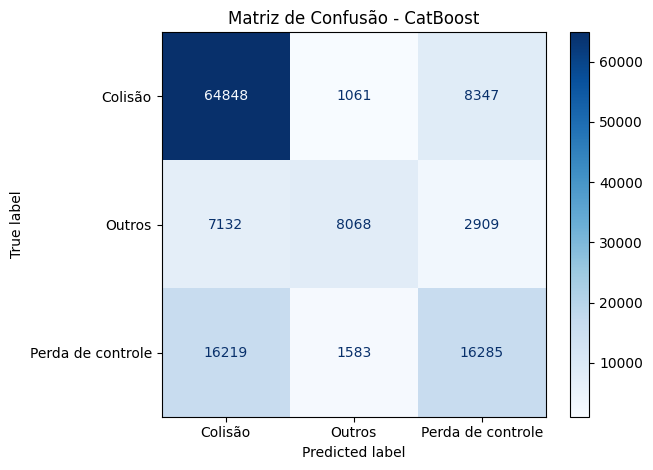

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - CatBoost')
plt.tight_layout()

### Modelo escolhido

Considerando a performance das combinações acima, o modelo escolhido é o TargetEncoder + XGBoost por ter uma acurácia de 70% (a maior até agora).